In [1]:
import numpy as np
import tensorflow as tf
import os
import random
from scipy.io import loadmat 
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, UpSampling2D, Input, Conv2DTranspose, DepthwiseConv2D
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as compare_ssim
from skimage.metrics import structural_similarity as ssim

2025-02-21 16:16:50.375329: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-21 16:16:50.389935: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740147410.406323  199147 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740147410.411383  199147 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-21 16:16:50.429482: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
###### Set random seeds for reproducibility

# Set all seeds for reproducibility
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)

# Ensure TensorFlow uses deterministic operations
tf.config.experimental.enable_op_determinism()
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

# Load the Pavia dataset
try:
    data = loadmat("Pavia.mat")  # Ensure that the file path is correct
except Exception as e:
    raise ValueError(f"Error loading .mat file: {e}")

# Access the hyperspectral image using the correct key 'pavia'
print("Keys in loaded .mat file:", data.keys())
if 'pavia' in data:
    hyperspectral_image = data['pavia']
else:
    raise KeyError("'pavia' not found in the .mat file.")

# Check the shape of the hyperspectral image
print("Hyperspectral image shape:", hyperspectral_image.shape)

# Convert to float32 for TensorFlow operations
hyperspectral_image = hyperspectral_image.astype(np.float32)

# Load the hyperspectral data using the spectral library
data = hyperspectral_image  # Use the loaded hyperspectral image directly

# Parameters
patch_size = (144, 144)  # Size of patches to extract
test_size = 0.2  # Proportion of data for testing
validation_size = 0.1  # Proportion of data for validation
downscale_factor = 2  # Factor to downscale patches
nodata_value = -1  # Value that indicates "no data"
group_size = 8 # Group size for spectral bands
overlap_size = 2  # Overlap size for grouped bands

# Function to group bands into overlapping subgroups
def group_bands_with_overlap(data, group_size=6, overlap_size=2):
    height, width, bands = data.shape
    step_size = group_size - overlap_size  # Calculate step size based on overlap
    grouped_data = []

    # Create overlapping groups of bands
    for g in range(0, bands - group_size + 1, step_size):
        group = data[:, :, g:g + group_size]
        grouped_data.append(group)
    
    return np.array(grouped_data)

# Extract and downscale patches from hyperspectral data
def extract_and_downscale_patches(data, patch_size, downscale_factor, nodata_value=0):
    patches_hr = []
    patches_lr = []
    height, width, bands = data.shape

    for i in range(0, height - patch_size[0] + 1, patch_size[0]):
        for j in range(0, width - patch_size[1] + 1, patch_size[1]):
            patch_hr = data[i:i + patch_size[0], j:j + patch_size[1], :]

            # Check for nodata_value and skip patch extraction if present
            if np.any(patch_hr == nodata_value):
                continue
            
            patch_lr = tf.image.resize(patch_hr, 
                                        [patch_size[0] // downscale_factor, patch_size[1] // downscale_factor], 
                                        method='bilinear')
            patches_hr.append(patch_hr)
            patches_lr.append(patch_lr.numpy())  # Convert tensor to numpy

    return np.array(patches_hr), np.array(patches_lr)

# Group bands into overlapping subgroups
grouped_data = group_bands_with_overlap(hyperspectral_image, group_size=group_size, overlap_size=overlap_size)

# Extract and downscale patches for all groups
all_patches_hr = []
all_patches_lr = []

for group in grouped_data:
    patches_hr, patches_lr = extract_and_downscale_patches(group, patch_size, downscale_factor, nodata_value=nodata_value)
    all_patches_hr.append(patches_hr)
    all_patches_lr.append(patches_lr)

# Concatenate patches from all groups
all_patches_hr = np.concatenate(all_patches_hr, axis=0)
all_patches_lr = np.concatenate(all_patches_lr, axis=0)

# Calculate the number of patches
num_patches = len(all_patches_hr)

# Calculate sizes for training, validation, and testing sets
train_size = int((1 - test_size - validation_size) * num_patches)
validation_size = int(validation_size * num_patches)
test_size = num_patches - (train_size + validation_size)  # Explicit calculation of test size

# Shuffle indices for splitting the data
indices = np.arange(num_patches)
np.random.shuffle(indices)
all_patches_hr = all_patches_hr[indices]
all_patches_lr = all_patches_lr[indices]

# Split into training, validation, and testing sets
X_train_hr, X_validation_hr, X_test_hr = np.split(all_patches_hr, [train_size, train_size + validation_size])
X_train_lr, X_validation_lr, X_test_lr = np.split(all_patches_lr, [train_size, train_size + validation_size])

# Print shapes to verify
print("X_train_hr shape:", X_train_hr.shape)
print("X_validation_hr shape:", X_validation_hr.shape)
print("X_test_hr shape:", X_test_hr.shape)

print("X_train_lr shape:", X_train_lr.shape)
print("X_validation_lr shape:", X_validation_lr.shape)
print("X_test_lr shape:", X_test_lr.shape)


Keys in loaded .mat file: dict_keys(['__header__', '__version__', '__globals__', 'pavia'])
Hyperspectral image shape: (1096, 715, 102)


I0000 00:00:1740147414.253269  199147 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31141 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:62:00.0, compute capability: 7.0


X_train_hr shape: (313, 144, 144, 8)
X_validation_hr shape: (44, 144, 144, 8)
X_test_hr shape: (91, 144, 144, 8)
X_train_lr shape: (313, 72, 72, 8)
X_validation_lr shape: (44, 72, 72, 8)
X_test_lr shape: (91, 72, 72, 8)


In [3]:

# -----------------------------
# Convolution Block with Optional Residual Connection and Depthwise Separable Convolution
# -----------------------------
def conv_block(x, filters, kernel_size=(3, 3), use_residual=False, use_depthwise=False, l2_reg=1e-4):
    shortcut = x  # Save the input as a shortcut

    if use_depthwise:
        x = DepthwiseConv2D(kernel_size, padding='same', use_bias=False, depthwise_regularizer=l2(l2_reg))(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(filters, (1, 1), padding='same', kernel_regularizer=l2(l2_reg))(x)
    else:
        x = Conv2D(filters, kernel_size, padding='same', kernel_regularizer=l2(l2_reg))(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
    
    if use_residual:
        shortcut = Conv2D(filters, (1, 1), padding='same', kernel_regularizer=l2(l2_reg))(shortcut)
        x = Add()([x, shortcut])
    
    return x

# -----------------------------
# Dilated Convolution Fusion Block
# -----------------------------
def dilated_convolution_fusion_block(x, filters, l2_reg=1e-4):
    spatial_branch = Conv2D(filters, (3, 3), dilation_rate=2, padding='same', activation='relu', kernel_regularizer=l2(l2_reg))(x)
    spectral_branch = Conv2D(filters, (1, 1), padding='same', activation='relu', kernel_regularizer=l2(l2_reg))(x)
    
    x = Add()([spatial_branch, spectral_branch])
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

# -----------------------------
# Enhanced Upsampling Block with Optional Residual Connection
# -----------------------------
def upsample_block(x, filters, scale=2, use_residual=False, use_depthwise=False, use_transpose=False):
    if not use_transpose:
        shortcut = UpSampling2D(size=(scale, scale), interpolation='bilinear')(x)
        shortcut = Conv2D(filters, (3, 3), padding='same')(shortcut)
        
        x = UpSampling2D(size=(scale, scale), interpolation='bilinear')(x)
        if use_depthwise:
            x = DepthwiseConv2D((3, 3), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            x = Conv2D(filters, (1, 1), padding='same')(x)
        else:
            x = Conv2D(filters, (3, 3), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
    else:
        shortcut = Conv2DTranspose(filters, (3, 3), strides=scale, padding='same')(x)
        shortcut = BatchNormalization()(shortcut)
        shortcut = Activation('relu')(shortcut)
        
        x = Conv2DTranspose(filters, (3, 3), strides=scale, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
    
    if use_residual:
        x = Add()([x, shortcut])
    
    return x

# -----------------------------
# Custom Loss Functions
# -----------------------------
def custom_loss_with_l2(y_true, y_pred, model):
    mse_loss = K.mean(K.square(y_true - y_pred))
    l2_loss_val = sum(K.sum(K.square(w)) for w in model.trainable_weights)
    l2_penalty = 1e-4 * l2_loss_val
    return mse_loss + l2_penalty

def spatial_spectral_gradient_loss(y_true, y_pred):
    grad_true_x, grad_true_y = tf.image.image_gradients(y_true)
    grad_pred_x, grad_pred_y = tf.image.image_gradients(y_pred)
    
    spatial_loss = K.mean(K.square(grad_true_x - grad_pred_x) + K.square(grad_true_y - grad_pred_y))
    
    grad_true_spectral = tf.gradients(tf.reduce_mean(y_true, axis=[1, 2]), y_true)[0]
    grad_pred_spectral = tf.gradients(tf.reduce_mean(y_pred, axis=[1, 2]), y_pred)[0]
    
    spectral_loss = K.mean(K.square(grad_true_spectral - grad_pred_spectral))
    
    return spatial_loss + spectral_loss

def combined_loss(y_true, y_pred, model):
    return custom_loss_with_l2(y_true, y_pred, model) + spatial_spectral_gradient_loss(y_true, y_pred)

# -----------------------------
# Build the Residual CNN Super-Resolution Model
# -----------------------------
def build_residual_cnn_sr_model(input_shape, use_depthwise=False, use_transpose=False, l2_reg=1e-4):
    inputs = Input(shape=input_shape)
    
    x = conv_block(inputs, filters=32, use_residual=True, use_depthwise=use_depthwise, l2_reg=l2_reg)
    x = dilated_convolution_fusion_block(x, filters=32, l2_reg=l2_reg)
    
    x = conv_block(x, filters=64, use_residual=True, use_depthwise=use_depthwise, l2_reg=l2_reg)
    x = dilated_convolution_fusion_block(x, filters=64, l2_reg=l2_reg)
    
    x = conv_block(x, filters=128, use_residual=True, use_depthwise=use_depthwise, l2_reg=l2_reg)
    x = dilated_convolution_fusion_block(x, filters=128, l2_reg=l2_reg)
    
    x = conv_block(x, filters=256, use_residual=True, use_depthwise=use_depthwise, l2_reg=l2_reg)
    x = dilated_convolution_fusion_block(x, filters=256, l2_reg=l2_reg)
    
    x = conv_block(x, filters=512, use_residual=True, use_depthwise=use_depthwise, l2_reg=l2_reg)
    x = dilated_convolution_fusion_block(x, filters=512, l2_reg=l2_reg)
    
    x = upsample_block(x, filters=64, scale=2, use_residual=True, use_depthwise=use_depthwise, use_transpose=use_transpose)
 #   x = upsample_block(x, filters=32, scale=2, use_residual=True, use_depthwise=use_depthwise, use_transpose=use_transpose)
#    x = upsample_block(x, filters=16, scale=2, use_residual=True, use_depthwise=use_depthwise, use_transpose=use_transpose)
    
    x_out = Conv2D(input_shape[-1], (3, 3), padding='same', kernel_regularizer=l2(l2_reg))(x)
    x_out = Activation('linear')(x_out)
    
    model = Model(inputs=inputs, outputs=x_out, name="Residual_CNN_SR_Model")
    return model

# -----------------------------
# Define Input Shape and Build the Model
# -----------------------------
input_shape = (72, 72, 8)  
residual_cnn_sr_model = build_residual_cnn_sr_model(input_shape, use_depthwise=True, use_transpose=True)

# Compile with Combined Loss
residual_cnn_sr_model.compile(optimizer='adam', loss=lambda y_true, y_pred: combined_loss(y_true, y_pred, residual_cnn_sr_model))

# Print model summary
residual_cnn_sr_model.summary()

# Count total trainable parameters
total_params = residual_cnn_sr_model.count_params()
print(f"Total Trainable Parameters: {total_params}")

Model: "Residual_CNN_SR_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 72, 72, 8) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d    │ (None, 72, 72, 8) │         72 │ input_layer[0][0] │
│ (DepthwiseConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 72, 72, 8) │         32 │ depthwise_conv2d… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 72, 72, 8) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 72, 72,    │        288 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 72, 72,    │        288 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 72, 72,    │          0 │ conv2d[0][0],     │
│                     │ 32)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 72, 72,    │      9,248 │ add[0][0]         │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 72, 72,    │      1,056 │ add[0][0]         │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 72, 72,    │          0 │ conv2d_2[0][0],   │
│                     │ 32)               │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │        128 │ add_1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_1  │ (None, 72, 72,    │        288 │ activation_1[0][… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │        128 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 72, 72,    │      2,112 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 72, 72,    │      2,112 │ activation_1[0][

 Total params: 4,449,872 (16.97 MB)

 Trainable params: 4,446,656 (16.96 MB)

 Non-trainable params: 3,216 (12.56 KB)

Total Trainable Parameters: 4449872


## Model's training

Epoch 1/1000


2025-02-21 16:16:57.005722: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
I0000 00:00:1740147425.779738  199617 service.cc:148] XLA service 0x7f12040210d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740147425.780614  199617 service.cc:156]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 2056028.0000

2025-02-21 16:17:29.428476: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_reduce_transpose_fusion_7', 8 bytes spill stores, 36 bytes spill loads

2025-02-21 16:17:30.741877: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[16,128,36,36]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,128,38,38]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-02-21 16:17:30.741894: W external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:874] None of the algorithms provided by cuDN

79/79 ━━━━━━━━━━━━━━━━━━━━ 36s 198ms/step - loss: 2056420.8750 - val_loss: 605289.5625
Epoch 2/1000
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 1814615.2500 - val_loss: 485659.7188
Epoch 3/1000
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 1526914.0000 - val_loss: 445798.2812
Epoch 4/1000
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 1219562.8750 - val_loss: 1030635.7500
Epoch 5/1000
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 924161.2500 - val_loss: 720131.7500
Epoch 6/1000
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 674912.6875 - val_loss: 471444.5312
Epoch 7/1000
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 488133.1250 - val_loss: 261408.9844
Epoch 8/1000
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 367450.4688 - val_loss: 163606.6875
Epoch 9/1000
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 288463.1875 - val_loss: 147289.6250
Epoch 10/1000
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 242006.8438 - val_loss: 182397.4844
Epoch 11/1000
79/79 ━━━━━━━━━━━━━━━

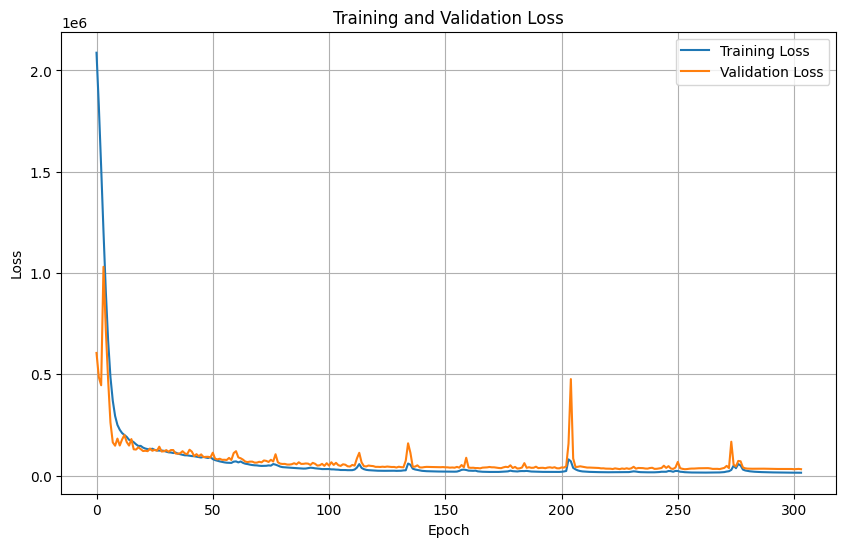

In [4]:
### # Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# Train the model and get the training history with early stopping
history = residual_cnn_sr_model.fit(
    X_train_lr, 
    X_train_hr, 
    epochs=1000, 
    batch_size=4, 
    validation_data=(X_validation_lr, X_validation_hr),
    callbacks=[early_stopping]  # Add the early stopping callback here
)

# Visualize training and validation loss over epochs
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)  # Add grid for better readability
plt.show()

## Report all the metrices such as PSNR , SSIM, SAM, CC, ERGAS, RMSE

In [5]:

def psnr(y_true, y_pred, max_pixel=None):
    """
    Compute PSNR for each spectral band separately and return the average.
    
    Args:
        y_true: Ground truth image, shape (H, W, B)
        y_pred: Super-resolved image, shape (H, W, B)
        max_pixel: Maximum pixel value (None = use actual max from y_true)
    
    Returns:
        Average PSNR across all bands
    """
    if max_pixel is None:
        max_pixel = np.max(y_true)  # Auto-detect max value if not provided

    B = y_true.shape[-1]  # Number of spectral bands
    psnr_values = []
    
    for i in range(B):  # Loop over bands
        mse = np.mean((y_true[..., i] - y_pred[..., i]) ** 2)
        if mse == 0:
            psnr_values.append(float('inf'))  # Perfect reconstruction
        else:
            psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
            psnr_values.append(psnr)
    
    return np.mean(psnr_values)  # Average across bands

# Function to calculate SSIM with channel_axis
def ssim_value(y_true, y_pred):
    if y_true.shape != y_pred.shape:
        raise ValueError(f"Shape mismatch: y_true shape {y_true.shape} vs y_pred shape {y_pred.shape}")
    
    data_range = y_true.max() - y_true.min()  # Calculate data range from y_true
    ssim_val = ssim(y_true, y_pred, data_range=data_range, channel_axis=-1)
    return ssim_val

# Function to calculate Correlation Coefficient
def correlation_coefficient(y_true, y_pred):
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    corr_matrix = np.corrcoef(y_true_flat, y_pred_flat)
    corr_value = corr_matrix[0, 1]
    return corr_value

# Function to calculate Spectral Angle Mapper (SAM) in degrees
def sam(y_true, y_pred):
    y_true_reshaped = y_true.reshape(-1, y_true.shape[-1])
    y_pred_reshaped = y_pred.reshape(-1, y_pred.shape[-1])
    
    non_zero_mask = (np.linalg.norm(y_true_reshaped, axis=1) > 1e-10) & (np.linalg.norm(y_pred_reshaped, axis=1) > 1e-10)
    dot_product = np.sum(y_true_reshaped[non_zero_mask] * y_pred_reshaped[non_zero_mask], axis=1)
    norm_true = np.linalg.norm(y_true_reshaped[non_zero_mask], axis=1)
    norm_pred = np.linalg.norm(y_pred_reshaped[non_zero_mask], axis=1)
    
    with np.errstate(divide='ignore', invalid='ignore'):
        angles = np.arccos(np.clip(dot_product / (norm_true * norm_pred), -1.0, 1.0))
    
    if angles.size > 0:
        sam_value_degrees = np.mean(angles) * (180 / np.pi)
    else:
        sam_value_degrees = 0
    
    return sam_value_degrees

# Function to normalize the images
def normalize(image):
    min_val = np.min(image)
    max_val = np.max(image)
    return (image - min_val) / (max_val - min_val)  # Normalize to [0, 1]

# Function to calculate Root Mean Squared Error (RMSE) for hyperspectral images (normalized)
def rmse_bandwise(y_true, y_pred):
    if y_true.shape != y_pred.shape:
        raise ValueError("Shape mismatch between true and predicted images.")
    
    bands = y_true.shape[-1]
    rmse_per_band = []

    for b in range(bands):
        band_true = y_true[:, :, b]
        band_pred = y_pred[:, :, b]
        
        mse_band = np.mean((band_true - band_pred) ** 2)
        rmse_band_value = np.sqrt(mse_band)
        rmse_per_band.append(rmse_band_value)

    # Normalize RMSE by the maximum value in y_true across all bands
    max_value = np.max(y_true)
    normalized_rmse = np.mean(rmse_per_band) / max_value
    return normalized_rmse

# Function to calculate ERGAS
def ergas(y_true, y_pred, scale):
    bands = y_true.shape[-1]
    ergas_value = 0
    
    for b in range(bands):
        band_true = y_true[:, :, b]
        band_pred = y_pred[:, :, b]
        mean_band_true = np.mean(band_true)
        
        # Calculate RMSE for the band without using a separate function
        mse_band = np.mean((band_true - band_pred) ** 2)  # Mean Squared Error for the band
        rmse_band = np.sqrt(mse_band)  # Root Mean Squared Error for the band
        
        ergas_value += (rmse_band / mean_band_true) ** 2
    
    ergas_value = 100 * (1 / scale) * np.sqrt(ergas_value / bands)
    return ergas_value

# Assuming hybrid_sr_model is trained, and X_test_lr, X_test_hr are defined
predicted_hr_images =  residual_cnn_sr_model.predict(X_test_lr, batch_size=4)

downscale_factor = 2 # ERGAS downscale factor

# Validate shapes match for test and predictions
if predicted_hr_images.shape != X_test_hr.shape:
    raise ValueError(f"Shape mismatch: predicted_hr_images shape {predicted_hr_images.shape} vs X_test_hr shape {X_test_hr.shape}")

# Calculate metrics per test sample
psnr_values, ssim_values, cc_values, sam_values, ergas_values, rmse_values = [], [], [], [], [], []

for i in range(len(X_test_hr)):
    psnr_values.append(psnr(X_test_hr[i], predicted_hr_images[i]))
    ssim_values.append(ssim_value(X_test_hr[i], predicted_hr_images[i]))
    cc_values.append(correlation_coefficient(X_test_hr[i], predicted_hr_images[i]))
    sam_values.append(sam(X_test_hr[i], predicted_hr_images[i]))
    ergas_values.append(ergas(X_test_hr[i], predicted_hr_images[i], downscale_factor))
    rmse_values.append(rmse_bandwise(X_test_hr[i], predicted_hr_images[i]))

# Average metrics
average_psnr = np.mean(psnr_values)
average_ssim = np.mean(ssim_values)
average_cc = np.mean(cc_values)
average_sam = np.mean(sam_values)
average_ergas = np.mean(ergas_values)
average_rmse = np.mean(rmse_values)

# Print the evaluation metrics
print("Average PSNR on the test set:", average_psnr)
print("Average SSIM on the test set:", average_ssim)
print("Average SAM on the test set (in degrees):", average_sam)
print("Average Correlation Coefficient on the test set:", average_cc)
print("Average ERGAS on the test set:", average_ergas)
print("Average RMSE:", average_rmse)  # Indicate RMSE is normalized

2025-02-21 16:43:33.473623: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


21/23 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

2025-02-21 16:43:36.016313: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[12,256,36,36]{3,2,1,0}, u8[0]{0}) custom-call(f32[12,256,38,38]{3,2,1,0}, f32[256,256,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-02-21 16:43:36.016329: W external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:874] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2025-02-21 16:43:36.016333: W external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:877] Conv: %cudnn-conv-bias-activation.87 = (f32[12,256,36,36]{3,2,1,0}, u8[0]{0}) custom-call(

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step
Average PSNR on the test set: 39.50195365227186
Average SSIM on the test set: 0.96571994
Average SAM on the test set (in degrees): 3.418970912039513
Average Correlation Coefficient on the test set: 0.9904555296131157
Average ERGAS on the test set: 3.998514506376669
Average RMSE: 0.011225838
